## Delanteros

In [3]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

df = pd.read_csv(next(iter(uploaded)))

df.head()

Saving delanteros_Rforest_dataset.csv to delanteros_Rforest_dataset.csv
Uploaded file: delanteros_Rforest_dataset.csv


,value,age,X90s,Goals,Shots,SoT.,ShoDist,PasShoCmp,PasMedCmp.,Assists,...,Touches,TouDef3rd,TouAttPen,ToAtt,ToTkl,Carries,Rec,Fls,AerWon,AerWon.
0,15.0,21,6.5,0,2.15,28.6,17.9,14.5,68.3,0.31,...,51.4,5.23,3.54,5.69,1.85,32.2,36.3,2.15,0.15,33.3
1,2.0,30,2.0,1,3.00,66.7,13.9,7.5,76.9,0.00,...,34.0,2.00,4.50,2.00,1.00,19.5,25.0,1.00,0.50,7.1
2,4.0,28,0.5,0,0.00,0.0,0.0,20.0,80.0,0.00,...,60.0,4.00,2.00,16.00,6.00,38.0,44.0,2.00,0.00,0.0
3,5.0,27,9.2,0,0.98,22.2,19.9,19.2,76.3,0.00,...,62.0,20.30,1.41,3.70,2.07,29.2,34.0,1.74,0.65,40.0
4,15.0,28,15.2,3,1.97,33.3,16.8,15.6,56.7,0.07,...,48.8,5.13,4.61,2.37,1.71,27.5,32.7,1.91,1.51,50.0


Llevamos a cabo el ajuste de hiperparámetros para un RandomForestRegressor, utilizando GridSearchCV de scikit-learn. Definimos un conjunto de hiperparámetros, ajustamos los modelos a los datos de entrenamiento y evaluamos su rendimiento en los datos de prueba con métricas como MAE, MAPE, R2 y RMSE. Por último, compilamos y resumimos los resultados en un DataFrame.

**Mejores Hiperparámetros**

In [4]:
# Búsqueda del mejor valor de cantidad de árboles, ajustado a la profundidad óptima encontrada (4)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px


seed = 123

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['value']), df['value'], test_size=0.2, random_state=seed)


maxdepth_list = []
min_samples_list = []
nestimator_list = []
max_leaf_nodes_list = []
MAPE_test_list = []
MAE_CV_list = []

max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10, 20]
max_leaf_nodes = [5, 10, 20, 30]
estimators = [50, 100, 200, 300]

for maxdepth in max_depth:
  for n_estimators in estimators:
    for samples in min_samples_split:
      for leaf_nodes in max_leaf_nodes:
        rf_model = RandomForestRegressor(random_state=seed, max_depth=maxdepth, n_estimators=n_estimators, min_samples_split=samples, max_leaf_nodes = leaf_nodes)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        #cross validation CV = 3 / SCORE = MAE
        scores = cross_val_score(rf_model, X_train, y_train, cv=3,scoring='neg_mean_absolute_error')
        mae_scores = -scores

        ## Generación de listas
        maxdepth_list.append(maxdepth)
        nestimator_list.append(n_estimators)
        min_samples_list.append(samples)
        max_leaf_nodes_list.append(leaf_nodes)
        MAPE_test_list.append(mean_absolute_percentage_error(y_test,y_pred))
        MAE_CV_list.append(mae_scores.mean()) # MAE

        df_grid = pd.DataFrame({"maxdepth":maxdepth_list,
                          "n_estimators":nestimator_list,
                           "min_samples":min_samples_list,
                           "max_leaf_nodes":max_leaf_nodes_list,
                           "MAPE_test":MAPE_test_list,
                            "MAE_CV":MAE_CV_list})


min_mae = df_grid["MAE_CV"].idxmin()
print('Los hiperparámetros ajustados al mínimo MAE son:')
print(df_grid.loc[min_mae])

Los hiperparámetros ajustados al mínimo MAE son:
maxdepth           15.000000
n_estimators      300.000000
min_samples         2.000000
max_leaf_nodes     20.000000
MAPE_test           1.432284
MAE_CV             14.649401
Name: 178, dtype: float64


**Grafico mejores parámetros**

In [5]:
fig = px.scatter(df_grid, x="MAE_CV", y="max_leaf_nodes", color="maxdepth",
                 size='min_samples', symbol = 'n_estimators')

fig.update_layout(
    title="Hyperparameter tuning (Delanteros)",
    autosize=True,
    width=900,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90),
    legend=dict(orientation="h", x=0.5, y=1.1),
    xaxis_title="Mean Absolute Error (CV)",
    yaxis_title="Max Leaf Nodes",
    coloraxis_colorbar_title="Max Depth",
    showlegend=True
)

fig.show()

**Mejor Modelo**

In [6]:
# Mejores hiperparámetros
best_params_x = {
    'max_depth': 5,
    'max_leaf_nodes': 5,
    'min_samples_split': 10,
    'n_estimators': 100
}

# Crear el mejor modelo
best_rf_model= RandomForestRegressor(random_state=123, **best_params_x)

# Ajustar el modelo a los datos de entrenamiento
best_rf_model.fit(X_train, y_train)

# Calcular el MAE para los datos de entrenamiento
y_pred_train = best_rf_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calcular el MAE para los datos de prueba
y_pred_test = best_rf_model.predict(X_test)
mae_test= mean_absolute_error(y_test, y_pred_test)

# Calcular el MAPE para los datos de entrenamiento y prueba
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100  # Multiplicado por 100 para convertirlo a porcentaje
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100  # Multiplicado por 100 para convertirlo a porcentaje

# Imprimir el MAE y el MAPE para la Iteración 2

print(f"MAE de entrenamiento: {mae_train}")
print(f"MAE de prueba: {mae_test}")
print(f"MAPE de entrenamiento (%): {mape_train}")
print(f"MAPE de prueba (%): {mape_test}")

MAE de entrenamiento: 12.482011061175504
MAE de prueba: 14.480792165899922
MAPE de entrenamiento (%): 148.1055280976189
MAPE de prueba (%): 166.120221409884


**Importancia de las Variables**

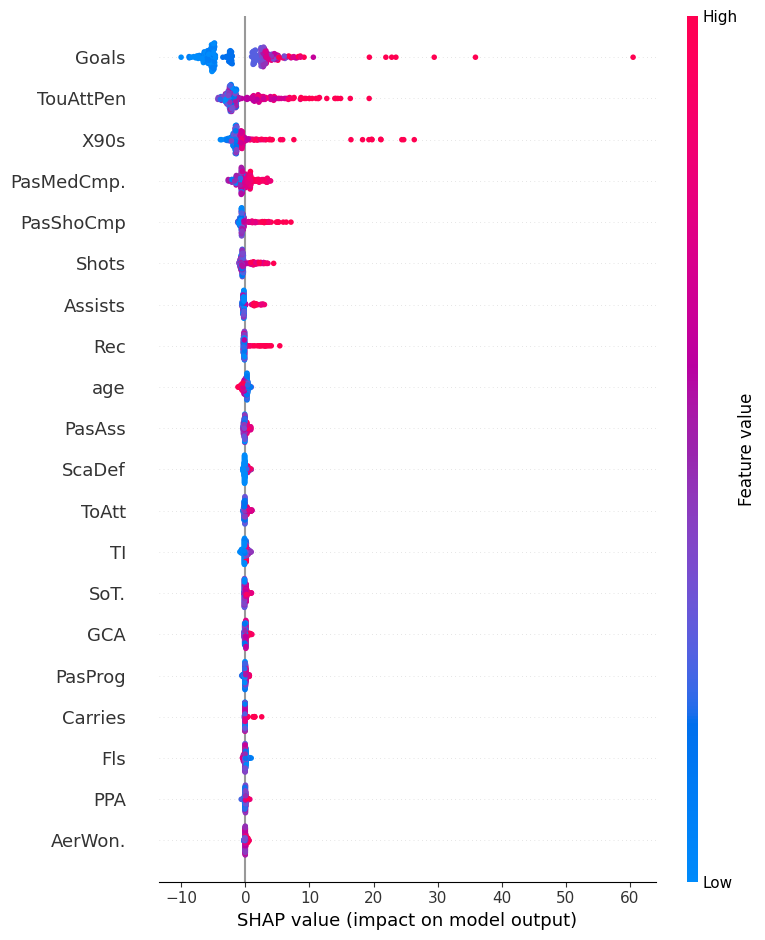

In [7]:
# Importa la biblioteca SHAP
!pip install shap
import shap

# Crear un objeto explicador SHAP con el mejor modelo
explainer = shap.Explainer(best_rf_model)

# Calcular los valores SHAP para el conjunto de entrenamiento
shap_values = explainer.shap_values(X_train)

# Graficar un resumen de los valores SHAP
shap.summary_plot(shap_values, X_train)